## Goals

- [x] make plot of # trial runs
- [ ] get prediction accuracy of the best model
  - run get_predictions.py
- [ ] scatterplot the performances


## Note

- every experiment is actually duplicated - RBP, RBP_extended
   - they both use the same features...
   
   
## Analysis ideas

- [ ] compare the performance across two replicates?
  - make scatterplots

In [16]:
from concise.hyopt import CMongoTrials, get_data
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import data
from glob import glob
import os
import concise.eval_metrics as cem

%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

def print_exp(exp_name):
    print("-" * 40 + "\nexp_name: " + exp_name)

PROC_DIR = "/s/project/deepcis/encode/eclip/processed"

DIR_ROOT = "/s/project/deepcis/encode/eclip/"
#DIR_ROOT = "/home/avsec/projects-work/deepcis/data/encode/eclip/"
RBP_LIST = [os.path.basename(x).replace(".csv", "")
           for x in glob(PROC_DIR + "/design_matrix/train/*.csv") if "_extended" not in x]

DB_NAME = "RBP__Eclip"
HOST = "ouga03"
#HOST = "localhost"

EXPERIMENTS = ["DeepNN_ext",
               "DeepNN_scalar_position_ext_gam",
               "DeepNN_scalar_position_ext_relu"]
#EXPERIMENTS = ["DeepNN_2",
#               "DeepNN_scalar_position_gam_2",
#               "DeepNN_scalar_position_relu_2"]
data_fn = data.data

## Number of finished trials

In [17]:
n_trials =  pd.DataFrame([{"exp": exp_name, 
                           "rbp": rbp, 
                           "n": len(CMongoTrials(DB_NAME, exp_name + "_" + rbp, ip=HOST))}
                             for exp_name in EXPERIMENTS
                             for rbp in RBP_LIST])

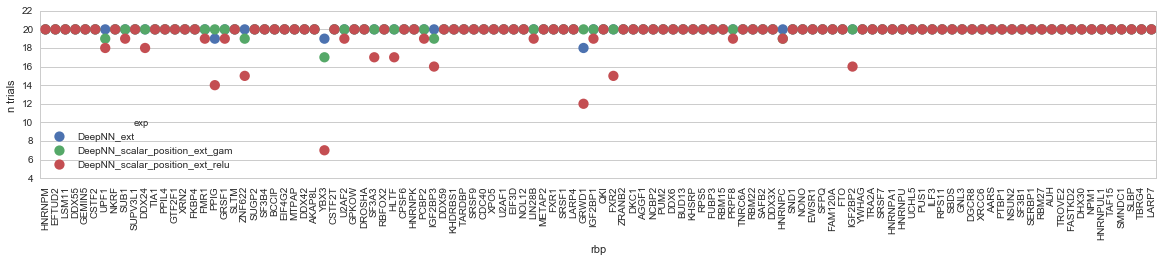

In [18]:
fig, ax = plt.subplots(figsize=(20,3))
sns.pointplot(x="rbp", y="n", hue="exp", data=n_trials, linestyles='', ax=ax);
plt.ylabel("n trials");
plt.xticks(rotation=90);

We can see that most of the points have the appropriate number of trials

In [19]:
dt_list = []
dt_pred_list = []
for rbp in RBP_LIST:
    for exp in EXPERIMENTS:
        path = "{root}/processed/predictions/{rbp}/{method}.csv".format(root=DIR_ROOT, rbp=rbp, method=exp)
        if os.path.exists(path):
            print(path)
            dt = pd.read_csv(path)
            del dt["Unnamed: 0"]
            dt["rbp"] = rbp
            dt["method"] = exp
            auc = cem.auc(dt["y_true"], dt["y_pred"])
            auprc = cem.auprc(dt["y_true"], dt["y_pred"])
            dtm = pd.DataFrame({"rbp": [rbp], "method": [exp], "auprc": [auprc], "auc": [auc]})
            dt_list.append(dtm)
            dt_pred_list.append(dt)
print("concat:")
dt_test = pd.concat(dt_list)
dt_pred_test = pd.concat(dt_pred_list)

/s/project/deepcis/encode/eclip//processed/predictions/HNRNPM/DeepNN_ext.csv
/s/project/deepcis/encode/eclip//processed/predictions/HNRNPM/DeepNN_scalar_position_ext_gam.csv
/s/project/deepcis/encode/eclip//processed/predictions/HNRNPM/DeepNN_scalar_position_ext_relu.csv
/s/project/deepcis/encode/eclip//processed/predictions/EFTUD2/DeepNN_ext.csv
/s/project/deepcis/encode/eclip//processed/predictions/EFTUD2/DeepNN_scalar_position_ext_gam.csv
/s/project/deepcis/encode/eclip//processed/predictions/EFTUD2/DeepNN_scalar_position_ext_relu.csv
/s/project/deepcis/encode/eclip//processed/predictions/LSM11/DeepNN_ext.csv
/s/project/deepcis/encode/eclip//processed/predictions/LSM11/DeepNN_scalar_position_ext_gam.csv
/s/project/deepcis/encode/eclip//processed/predictions/LSM11/DeepNN_scalar_position_ext_relu.csv
/s/project/deepcis/encode/eclip//processed/predictions/DDX55/DeepNN_ext.csv
/s/project/deepcis/encode/eclip//processed/predictions/DDX55/DeepNN_scalar_position_ext_gam.csv
/s/project/deep

In [12]:
# TODO - bootstrap?

In [20]:
dtt = dt_test.set_index(["rbp", "method"]).unstack()

In [21]:
dtt

auc                                                                     auprc  \
method DeepNN_ext DeepNN_scalar_position_ext_gam DeepNN_scalar_position_ext_relu DeepNN_ext   
rbp                                                                                           
AARS       0.7631                    0.8653                         0.7864           0.4737   
AGGF1      0.8571                    0.9087                         0.8885           0.6850   
AKAP8L     0.8490                    0.8860                         0.8704           0.6658   
...           ...                       ...                            ...              ...   
YWHAG      0.7679                    0.8330                         0.7829           0.5120   
ZNF622     0.9192                    0.9745                         0.9706           0.7525   
ZRANB2     0.8282                    0.8596                         0.8476           0.5735   

                                                                       
method DeepNN_scalar_position_ext_gam DeepNN_scalar_position_ext_relu  
rbp                                                                    
AARS                      0.6163                         0.5198        
AGGF1                     0.7745                         0.7377        
AKAP8L                    0.7237                         0.6946        
...                          ...                            ...        
YWHAG                     0.6153                         0.5254        
ZNF622                    0.9049                         0.8930        
ZRANB2                    0.6554                         0.5957        

[112 rows x 6 columns]

In [22]:
def splot_metric(dt, method1, method2, metric="auc", ax=None):
    ax = ax or plt.gca()
    xy = np.linspace(dt[metric][[method1, method2]].min().min(), 
                     dt[metric][[method1, method2]].max().max())
    ax.plot(xy, xy, c="grey", alpha=0.4)
    ax.scatter(dt[metric][method1], dt[metric][method2])
    ax.set_xlabel(method1 + " " + metric)
    ax.set_ylabel(method2 + " " + metric)
    ax.set_title(metric)

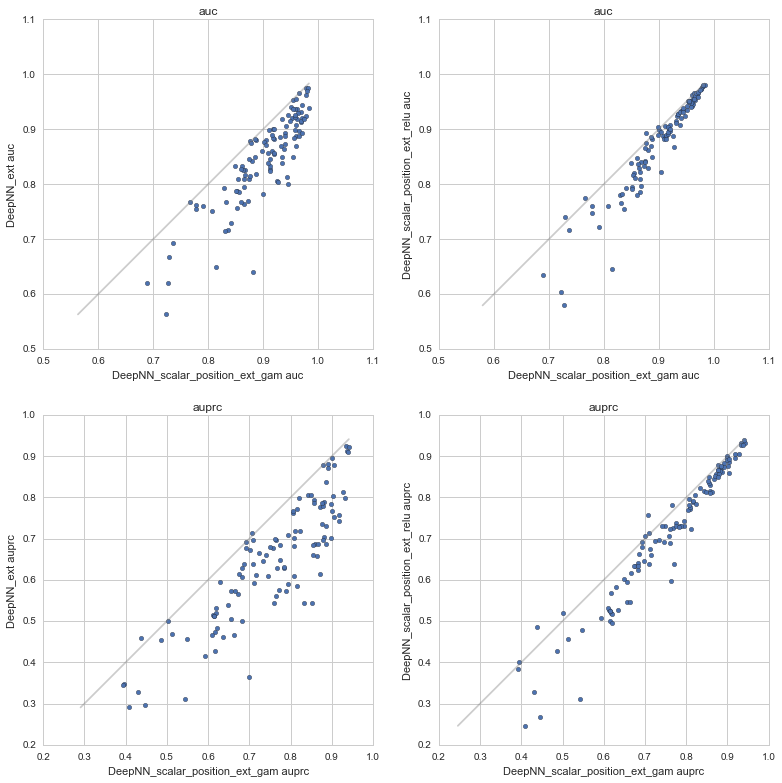

In [24]:
fig, ax = plt.subplots(2,2, figsize=(13,13))
splot_metric(dtt, "DeepNN_scalar_position_ext_gam", "DeepNN_ext", "auc", ax[0, 0])
splot_metric(dtt, "DeepNN_scalar_position_ext_gam", "DeepNN_ext", "auprc", ax[1, 0])
splot_metric(dtt, "DeepNN_scalar_position_ext_gam", "DeepNN_scalar_position_ext_relu", "auc", ax[0, 1])
splot_metric(dtt, "DeepNN_scalar_position_ext_gam", "DeepNN_scalar_position_ext_relu", "auprc", ax[1, 1])

In [121]:
np.mean((dtt["auprc"]["DeepNN_scalar_position_gam_2"] - dtt["auprc"]["DeepNN_scalar_position_relu_2"]) > 0)

0.5

In [124]:
gam_pos = (dtt["auprc"]["DeepNN_scalar_position_gam_2"] - dtt["auprc"]["DeepNN_2"]) > 0

In [125]:
relu_pos = ((dtt["auprc"]["DeepNN_scalar_position_relu_2"] - dtt["auprc"]["DeepNN_2"]) > 0)

In [127]:
pos_effect = gam_pos & relu_pos

In [135]:
np.mean((dtt["auprc"]["DeepNN_scalar_position_gam_2"][pos_effect] - 
         dtt["auprc"]["DeepNN_scalar_position_relu_2"][pos_effect]) > 0)

0.45454545454545453

In [136]:
np.mean((dtt["auc"]["DeepNN_scalar_position_gam_2"][pos_effect] - 
         dtt["auc"]["DeepNN_scalar_position_relu_2"][pos_effect]) > 0)

0.48484848484848486

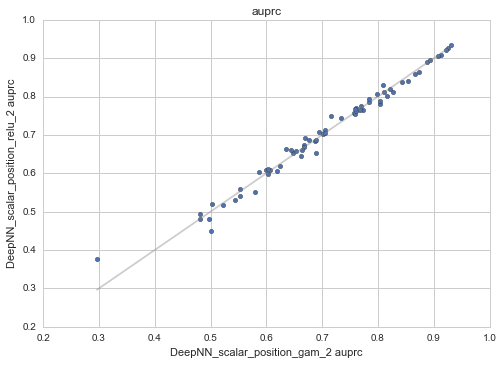

In [129]:
splot_metric(dtt[pos_effect], "DeepNN_scalar_position_gam_2", "DeepNN_scalar_position_relu_2", "auprc")

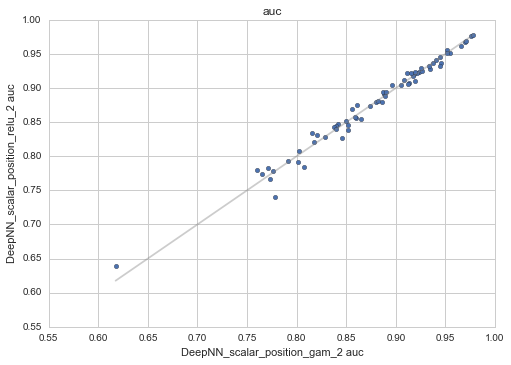

In [130]:
splot_metric(dtt[pos_effect], "DeepNN_scalar_position_gam_2", "DeepNN_scalar_position_relu_2", "auc")